### Wiktor Pilarczyk nr indeksu: 308533

Ustawianie precyzji obliczeń

In [21]:
setprecision(64)
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("Polynomials")
import Pkg; Pkg.add("PyPlot")
using Plots
using Polynomials

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


Funkcja initarray służy do zainicjalizowania tablicy o k elementach.

In [22]:
function initarray(tab, val, k)
    for i in 1:1:k
        append!(tab,BigFloat(val))
    end
end

initarray (generic function with 1 method)

# Wielomian optymalny w bazie ortogonalnej
## Obliczanie wartości bazy ortogonalnej w punktach $x_{i}$
Korzystając ze związku rekurencyjnego:
$$P_{0}(x) = 1 \ \ \ \ \ \ \ \ \ \ \ \ P_{1}(x) = 1 - a_{1}$$
$$P_{k}(x) = (x - a_{k}) P_{k-1}(x) - b_{k}P_{k-2}(x) $$
gdzie
$$a_{k} = \frac{<xP_{k-1},P_{k-1}>}{<P_{k-1},P_{k-1}>} \ \ \ \ \ \ b_{k} = \frac{<P_{k-1},P_{k-1}>}{<P_{k-2},P_{k-2}>}$$

Na podstawie powyższej zależności rekurencyjnej funkcja nextbase będzie obliczała wartości $P_{k}(x)$ w punktach $x_{i}$.

In [23]:
function nextbase(x, base1, base2, base3, a, b, k)
    c = BigFloat(0.0)
    d = BigFloat(0.0)
    e = BigFloat(0.0)
    
    for i in 1:1:k #wyliczanie wspolczynnikow c i d
        var = BigFloat(base2[i]) * BigFloat(base2[i])
        c += BigFloat(x[i]) * BigFloat(var)
        d += BigFloat(var)
        e += BigFloat(base1[i]) * BigFloat(base1[i])
    end
    #print("\nc:",c,"\nd:",d,"\n")
    c /= BigFloat(d)
    d /= BigFloat(e)
    append!(a, BigFloat(c))
    append!(b, BigFloat(d))
    #a[lvl] = c
    #b[lvl] = d
    
    for i in 1:1:k #obliczanie wartosci wielomianu z bazy w punktach xk
        base3[i] = (BigFloat(x[i]) - BigFloat(c)) * BigFloat(base2[i]) - BigFloat(d) * BigFloat(base1[i])
    end
    
end

nextbase (generic function with 1 method)

## Obliczanie wartości n-tego wielomianu optymalnego w punktach $x_{i}$
Wiemy, że wielomian optymalny można przedstawić za pomocą wzoru:
$$w_{n}^{*}(x) = \sum_{i=0}^{n} \alpha_{i}B_{i}(x) = \sum_{i=0}^{n} \frac{<f,B_{i}>}{<B_{i},B_{i}>}B_{i}(x)$$
korzystając z tego, że poprzedni wielomian został obliczony to 
$$w_{n}^{*}(x) = \frac{<f,B_{n}>}{<B_{n},B_{n}>}B_{n}(x) + \sum_{i=0}^{n-1} \frac{<f,B_{i}>}{<B_{i},B_{i}>}B_{i}(x) = \frac{<f,B_{n}>}{<B_{n},B_{n}>}B_{n}(x) + w_{n-1}^{*}(x) $$

Na podstawie powyższej zależności rekurencyjnej funkcja będzie obliczała wartości $w_{n}(x)$ w punktach $x_{i}$.

In [24]:
function nextpolynomial(x, wiel, base, fun, alfa, k)
    a = BigFloat(0.0)
    b = BigFloat(0.0)
    c = BigFloat(0.0)
    for i in 1:1:k #wyliczanie wspolczynika alfa
        a += BigFloat(base[i]) * BigFloat(fun[i]) 
        b += BigFloat(base[i]) * BigFloat(base[i])
        #print("\n: ",tabb[i],"  ", fun[i])
    end
    # alfa[lvl] = a/b
    #print("\na: ",a)
    #print("\nb: ",b)
    append!(alfa, BigFloat(a/b))
    
    for i in 1:1:k #wyliczanie wartosci wielomianu optymalnego stopnia lvl w punktach xk
        wiel[i] += BigFloat(a/b) * BigFloat(base[i])
    end
end

nextpolynomial (generic function with 1 method)

## Obliczanie potęgowej postaci wielomianu optymalnego
Otrzymany wielomian ma postać:
$$w_{n} =  \sum_{i=0}^{n} \alpha_{i}B_{i}(x)$$
Baza jest zadana poprzez zależność rekurencyjną:
$$P_{0}(x) = 1 \ \ \ \ \ \ \ \ \ \ \ \ P_{1}(x) = 1 - a_{1}$$
$$P_{k}(x) = (x - a_{k}) P_{k-1}(x) - b_{k}P_{k-2}(x) $$
gdzie
$$a_{k} = \frac{<xP_{k-1},P_{k-1}>}{<P_{k-1},P_{k-1}>} \ \ \ \ \ \ b_{k} = \frac{<P_{k-1},P_{k-1}>}{<P_{k-2},P_{k-2}>}$$
Więc można skorzystać z uogólnionego algorytmu Clenshawa:
$$V_{k} = \alpha_{k} + (x - a_{k+1})V_{k+1} - b_{k+2}V_{k+2}$$
gdzie
$$V_{n+1} = V_{n+2} = 0$$
wtedy
$$w_{n}^{*} = V_{0}$$

Na podstawie powyższej zależności rekurencyjnej funkcja będzie obliczała postać potęgową wielomianu optymalnego.

In [25]:
function Clenshaw(alfa, a, b,res)
    n = length(alfa)
    vk = []
    vk1 = []
    vk2 = []
    append!(b,0) #gdyz w petli odowalmy sie do elemntu b_n+1
    initarray(vk, BigFloat(0), n)
    initarray(vk1, BigFloat(0), n)
    initarray(vk2, BigFloat(0), n)
    vk1[1] = BigFloat(alfa[n])
    for i in n - 1:-1:1
        vk[1] += BigFloat(alfa[i])
        for j in 1:1:n
            vk[j] -= BigFloat(a[i]) * BigFloat(vk1[j])
            vk[j] -= BigFloat(b[i+1]) * BigFloat(vk2[j])
            if j != n
                vk[j+1] += BigFloat(vk1[j])
            end
        end
        for j in 1:1:n
            vk2[j] = BigFloat(vk1[j])
            vk1[j] = BigFloat(vk[j])
            vk[j] = BigFloat(0.0)
        end
    end
    initarray(res, BigFloat(0), n)
    for j in 1:1:n
        res[j] = BigFloat(vk1[j])
    end
end

Clenshaw (generic function with 1 method)

## Kontrola warunku
Funkcja optimalenough sprawdza czy wielomian optymalny spełnia warunek:
$$\sum_{k=0}^{r} [w(x_{k}) - f_{k}]^{2} < \delta$$


In [26]:
function optimalscalar(w, fun, k)
    sum = BigFloat(0.0)
    for i in 1:1:k
        #print((BigFloat(w[i]) - BigFloat(fun[i])) * (BigFloat(w[i]) - BigFloat(fun[i])), "a\n")
        sum += (BigFloat(w[i]) - BigFloat(fun[i])) * (BigFloat(w[i]) - BigFloat(fun[i]))
        #print(sum, "\n")
    end
    #print(sum)
    return BigFloat(sum)
end

function optimalenough(w, fun, delta, k)
    sum = optimalscalar(w, fun, k)
    if sum >= delta
        return false
    end
    return true
end 

optimalenough (generic function with 1 method)

## Szukanie wielomianu
Funkcja findoptimal znajduje wielomian optymalny jak najmniejszego stopnia, aby spełniał powyższy warunek, 
a następnie za pomocą uogólnionego algorytmu Clenshawa oblicza postać potęgową tego wielomianu.

In [27]:
function findoptimal(x, fun, delta, res)
    k = length(x)
    base1 = [] #obliczenie dwóch pierwszych elementów bazy
    base2 = []
    base3 = []
    a = []
    b = [BigFloat(0.0)]
    alfa = []
    w = []
    initarray(base1, BigFloat(1.0), k)
    initarray(base2, BigFloat(0.0), k)
    initarray(base3, BigFloat(0.0), k)
    var1 = BigFloat(0.0)
    
    for i in 1:1:k #wyliczanie a1
        var1 += BigFloat(x[i])
    end
    append!(a,BigFloat(var1/k))
    
    var1 = BigFloat(0.0)
    for i in 1:1:k
        var1 += BigFloat(fun[i])
    end
    append!(alfa, BigFloat(var1/k))
    initarray(w, BigFloat(alfa[1]), k)
    if optimalenough(w, fun ,delta, k)
        Clenshaw(alfa, a, b, res)
        return
    end
    
    for i in 1:1:k #wyliczanie drugie elementu bazy
        base2[i] = x[i] - a[1]
    end
    
    nextpolynomial(x, w, base2, fun, alfa, k)
    #print("\base2: ",base2)
    #print("\nalfa[1]: ",alfa[1])
    #print("\nalfa[2]: ",alfa[2])
    #print("\na[1]: ",a[1])
    while !optimalenough(w, fun ,delta, k)
        nextbase(x, base1, base2, base3, a, b, k)
        for i in 1:1:k
            base1[i] = BigFloat(base2[i])
            base2[i] = BigFloat(base3[i])
        end
        nextpolynomial(x, w, base2, fun, alfa, k)
    end
    #print(alfa,"\n", a,"\n", b,"\n")
    Clenshaw(alfa, a, b, res)
end

function findnthoptimal(x, fun, n, res) # funkcja znajdujaca n - ty wiel optymalny
    k = length(x)
    base1 = [] #obliczenie dwóch pierwszych elementów bazy
    base2 = []
    base3 = []
    a = []
    b = [BigFloat(0.0)]
    alfa = []
    w = []
    initarray(base1, BigFloat(1.0), k)
    initarray(base2, BigFloat(0.0), k)
    initarray(base3, BigFloat(0.0), k)
    var1 = BigFloat(0.0)
    
    for i in 1:1:k #wyliczanie a1
        var1 += BigFloat(x[i])
    end
    append!(a,BigFloat(var1/k))
    
    var1 = BigFloat(0.0)
    for i in 1:1:k
        var1 += BigFloat(fun[i])
    end
    append!(alfa, BigFloat(var1/k))
    initarray(w, BigFloat(alfa[1]), k)
    if optimalenough(w, fun, 4.9406564584124654e-320, k) || n == 0
        Clenshaw(alfa, a, b, res)
        return
    end
    n -= 1
    
    for i in 1:1:k #wyliczanie drugie elementu bazy
        base2[i] = x[i] - a[1]
    end
    
    nextpolynomial(x, w, base2, fun, alfa, k)
    #print("\base2: ",base2)
    #print("\nalfa[1]: ",alfa[1])
    #print("\nalfa[2]: ",alfa[2])
    #print("\na[1]: ",a[1])
    while !optimalenough(w, fun, 4.9406564584124654e-320, k) && n > 0
        n -= 1
        nextbase(x, base1, base2, base3, a, b, k)
        for i in 1:1:k
            base1[i] = BigFloat(base2[i])
            base2[i] = BigFloat(base3[i])
        end
        nextpolynomial(x, w, base2, fun, alfa, k)
    end
    #print(alfa,"\n", a,"\n", b,"\n")
    Clenshaw(alfa, a, b, res)
end

findnthoptimal (generic function with 1 method)

# Obliczanie wielomianu optymalnego wielomianu w bazie {$1, x, x^{2}, …$}
## Obliczanie wartości współczynników
Otrzymany układ równań:
$$
\begin{pmatrix}
  <B_{0},B_{0}> & <B_{1},B_{0}> & \cdots & <B_{k},B_{0}> \\
  <B_{0},B_{1}> & <B_{1},B_{1}> & \cdots & <B_{k},B_{1}> \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  <B_{0},B_{k}> & <B_{1},B_{k}> & \cdots & <B_{k},B_{k}> 
 \end{pmatrix}
\begin{bmatrix}
    \alpha_{0} \\
    \alpha_{1} \\
    \vdots  \\
    \alpha_{k} \\
  \end{bmatrix} 
  =
  \begin{bmatrix}
    <f, B_{0}>  \\
    <f, B_{1}>  \\
    \vdots  \\
    <f, B_{k}>  \\
  \end{bmatrix}
$$
mnożymy lewostronnie przez odwrotność macierzy i otrzymujemy wektor wspołczynników:

$$
    alpha = B^{-1} * f
$$

In [28]:
function scalar(x, i, y, j) #Oblicza ilocznyn skalarny oraz podnosci elementy do potęgi i/j
    sum = BigFloat(0)
    for g in 1:1:length(x)
        a = BigFloat(1)
        b = BigFloat(1)
        for h in 1:1:i
            a *= x[g]
        end
        for h in 1:1:j
            b *= y[g]
        end
        sum += a*b
    end
    return sum
end
            
function nextstandard(alpha, x, fun, k)
    M = Array{Float64,2}(UndefInitializer(), k+1, k+1)
    f = Array{Float64,2}(UndefInitializer(), k+1, 1)
    a = Array{Float64,2}(UndefInitializer(), k+1, 1)
    for i in 0:1:k
        f[i+1,1] = BigFloat(scalar(fun, 1, x, i))
        for j in 0:1:k
            M[i+1,j+1] = BigFloat(scalar(x,j,x,i)) #Zakładam, że macierz jest odwracalna
        end
    end
    #print("\nNextstandard:",M)
    #print("\nNextstandard:",inv(M),"\n")
    a = inv(M)*f
    for i in 0:1:k
        append!(alpha,a[i+1][1])
    end
end

function calculatepoly(alfa, x, w)
    for i in 1:1:length(x)
        wart = BigFloat(alfa[length(alfa)])
        for j in length(alfa)-1:-1:1
            wart *= BigFloat(x[i])
            wart += BigFloat(alfa[j])
        end
        append!(w, wart)
    end
end                          

function findstandardpoly(x, fun, delta, result)
    deg = 0
    res = []
    w = []
    nextstandard(res, x, fun, deg)
    calculatepoly(res, x, w)
    while !optimalenough(w, fun ,delta, length(x))
        deg += 1
        res = []
        w = []
        nextstandard(res, x, fun, deg)
        calculatepoly(res, x, w)
    end
    for i in 1:1:length(res)
        append!(result, res[i])
    end
end

function findnthstandardpoly(x, fun, n, result)
    deg = 0
    res = []
    w = []
    nextstandard(res, x, fun, deg)
    calculatepoly(res, x, w)
    while !optimalenough(w, fun ,4.9406564584124654e-30, length(x)) && n > 0
       #print("\nHalo\n", res)
        n -= 1
        deg += 1
        res = []
        w = []
        nextstandard(res, x, fun, deg)
        calculatepoly(res, x, w)
    end
    for i in 1:1:length(res)
        append!(result, res[i])
    end
end

findnthstandardpoly (generic function with 1 method)

# Porównanie błedu dla róznych stopni wielomianu optymalnego przy liczeniu z baza ortogonalną i bazą {$1, x, x^{2}, ...$}
Funkcja comparepoly wylicza wielomiany optymalne danego stopnia dla bazdy ortogonalnej i {$1, x, x^{2}, ...$} i zwraca odległość wyliczonego wielomianu optymalnego od wielomianu przybliżanego.

In [50]:
function comparepoly(x,fun, n)
    if n >= length(x) - 1
        n = length(x) - 1
    end
    
    wiel = Array{Float64,1}(UndefInitializer(), 0)
    res = Array{Float64,1}(UndefInitializer(), 0)
    findnthstandardpoly(x,fun, n, wiel)
    calculatepoly(wiel, x, res)
    #print(res)
    a = BigFloat(optimalscalar(res, fun, length(fun)))
    #print(wiel)
    
    wiel = Array{Float64,1}(UndefInitializer(), 0)
    res = Array{Float64,1}(UndefInitializer(), 0)
    findnthoptimal(x, fun, n, wiel)
    calculatepoly(wiel, x, res)
    b = optimalscalar(res, fun, length(fun))
    
    return (a,b)
end
    

comparepoly (generic function with 1 method)

In [69]:
x = [0,10,20,30,40,80,90,95]
fun = [68.0, 67.1, 66.4, 65.6, 64.6, 61.8, 61, 60]

#przyklad z listy 7 zad 8
for i in 0:1:7
    a,b = comparepoly(x, fun, i)
    print(abs(b-a), " ", abs((b-a)/min(b,a)), "\n")
end

0.0 0.0
6.4666425426268547838e-15 2.3202703019193659142e-14
5.95172782585917659048e-16 2.15697453512714472894e-15
2.04710922692419305946e-16 1.1984356827452159378e-15
2.79033659242658438338e-15 3.0958144686251811424e-14
1.98817690961897511337e-17 8.34205522111729474868e-15
3.79439519379464424651e-14 6.98951427161064421676e-10
4.2628897304417041039e-10 6.03108786328256835312e+17


In [57]:
x = [-1.00, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0]
fun = [-0.2209, 0.3259, 0.8826, 1.4392, 2.003, 2.5645, 3.1334, 3.7061, 4.2836]
#przyklad z treści zadania 
for i in 0:1:8
    a,b = comparepoly(x, fun, i)
    print(abs(b-a), " ", abs((b-a)/min(b,a)), "\n")
end

0.0 0.0
1.09788175458366138448e-17 1.0043946532488746388e-14
2.24519152123430642707e-19 1.49576263819501271238e-14
6.83002204604422398114e-19 4.60670739616362159977e-14
9.53692096978725386549e-19 1.195567356801952628e-13
6.35853736869512373674e-20 1.13393915307046848304e-14
4.85905744148349728884e-19 8.67019965614943267926e-14
7.37562624218113827034e-19 1.43160425656499147172e-13
1.24392645927077572376e-22 2.83282256435087719304e+09


In [62]:
x = [1,2,3,4,5]
fun = [1,32,243,1024,3125]
#funkcja x^5 dla punktów równoodległych
for i in 0:1:4
    a,b = comparepoly(x, fun, i)
    print(abs(b-a), " ", abs((b-a)/min(b,a)), "\n")
end

0.0 0.0
0.0 0.0
2.70858890871750190854e-11 2.05489686142785250174e-16
7.16227077646180987358e-12 3.8685104502494444238e-15
6.40073430055923567696e-14 Inf


In [63]:
x = [0.1,0.2,0.3,3,5]
fun = [0.00001,0.00032,0.00243,243,3125]
#funkcja x^5
for i in 0:1:4
    a,b = comparepoly(x, fun, i)
    print(abs(b-a), " ", abs((b-a)/min(b,a)), "\n")
end

0.0 0.0
2.4851942725945264101e-10 1.38738301998641909944e-16
2.88480350718600675464e-12 2.97843185258049420506e-16
1.86699614102003863536e-16 2.10192528191938377898e-16
8.05861520370845866832e-11 3.38460738528103762939e+15


In [34]:
#funkcja zwracajaca tablice wartosci w zadanych punktach dla x^(x * sin(x))
function calculfunc(points, res)
    n = length(points)
    for i in 1:1:n
        append!(res,BigFloat(points[i]^BigFloat(points[i] * sin(points[i]))))
    end
end
#funkcja zwracajaca tablice wartosci w zadanych punktach dla sin(x)
function calculfunc2(points, res)
    n = length(points)
    for i in 1:1:n
        append!(res,BigFloat(sin(points[i])))
    end
end

calculfunc2 (generic function with 1 method)

In [64]:
x = [1,1.5,2,2.5,3,3.5,4,4.5,5]
func = Array{Float64,1}(UndefInitializer(), 0)
calculfunc(x,func)
#funkcja x ^(x * sin(x))
for i in 0:1:8
    a,b = comparepoly(x, func, i)
    print(abs(b-a), " ", abs((b-a)/min(b,a)), "\n")
end

0.0 0.0
1.26895022267703438956e-15 1.08097154787231143443e-16
7.11236625150490908709e-17 8.06295290304171003028e-18
2.12503625807158869065e-17 7.94958973542625150593e-18
3.04660810468426745956e-16 1.14108138575121590048e-16
1.53251977080826051747e-16 2.7230783488180611934e-16
1.77558434535235454277e-14 6.02480640720695684293e-14
3.86234827147858943153e-11 3.9093339838957780106e-10
2.21780378528282783894e-07 1.57315010560863976841e+13


In [65]:
x = [-12.56, -12.55, 12.54, 12.55, 12.56]
func = Array{Float64,1}(UndefInitializer(), 0)
calculfunc2(x,func)
#funkcja sin(x) dla punktów różnoodległych
for i in 0:1:4
    a,b = comparepoly(x, func, i)
    print(abs(b-a), " ", abs((b-a)/min(b,a)), "\n")
end

1.05879118406787542384e-22 9.02394487735003525477e-20
1.32348898008484427979e-22 5.28369542100590362714e-19
4.86382200181180272824e-20 3.03384750842936025977e-16
4.00526264815074540491e-22 4.83853479224429608659e-12
8.72193459067615312206e-11 2.4043177020238999178e+19


# Przykłady

wspolczynniki otrzymanego wielomianu:[64.3125]
wspolczynniki otrzymanego wielomianu:[67.95932257043368, -0.07993035770813547]
wspolczynniki otrzymanego wielomianu:[68.0549165436904, -0.10370661634711476, 0.0008304599950821998, -6.42036447484241e-6]
wspolczynniki otrzymanego wielomianu:[67.95170130546234, -0.060267521774507324, -0.0015491336785289675, 3.3415817679400464e-5, -2.0612634962939103e-7]


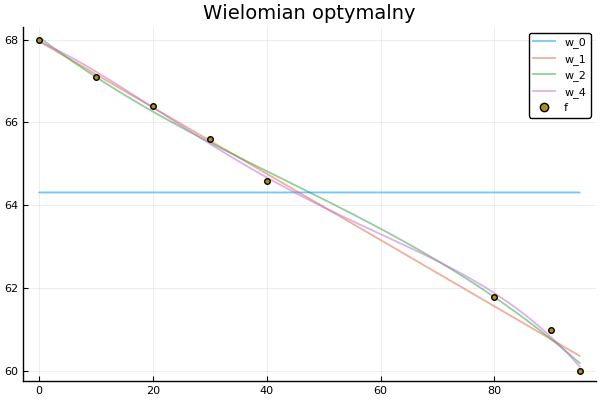

In [37]:
x = [0,10,20,30,40,80,90,95]
fun = [68.0, 67.1, 66.4, 65.6, 64.6, 61.8, 61, 60]

#przyklad z listy 7 zad X
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0) 
wiel2 = Array{Float64,1}(UndefInitializer(), 0) 
wiel3 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,fun, 100, wiel)
findoptimal(x,fun, 1, wiel1)
findoptimal(x,fun, 0.27, wiel2)
findoptimal(x,fun, 0.1, wiel3)

print("wspolczynniki otrzymanego wielomianu:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel1,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel2,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel3,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
p2 = Poly(wiel2)
p3 = Poly(wiel3)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs), p2.(xs), p3.(xs)],seriesalpha = 0.55, linewidth=1.3, title="Wielomian optymalny", label=[ "w_0" "w_1" "w_2" "w_4"])
scatter!(x, fun, label="f")

wspolczynniki otrzymanego wielomianu w:[2.0130444444444446, 2.2523666666666666]
wspolczynniki otrzymanego wielomianu w1:[2.0005718614718613, 2.2523666666666666, 0.029934199134199094]
wspolczynniki otrzymanego wielomianu w2:[2.0005718614718613, 2.251830303030303, 0.029934199134199094, 0.0007272727272727553]
wspolczynniki otrzymanego wielomianu w3:[2.0016247086247088, 2.251830303030303, 0.020965501165501593, 0.0007272727272727553, 0.00873473193473148]


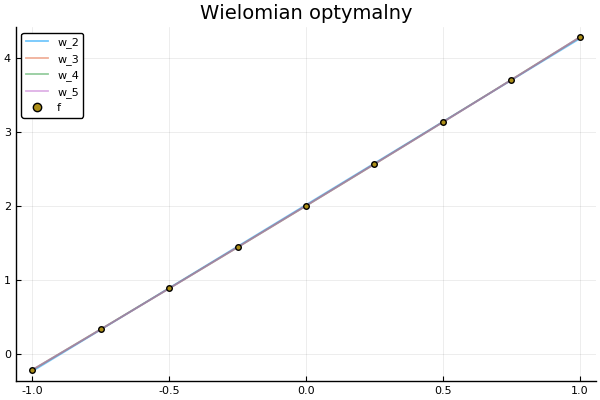

In [38]:
x = [-1.00, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0]
fun = [-0.2209, 0.3259, 0.8826, 1.4392, 2.003, 2.5645, 3.1334, 3.7061, 4.2836]
#przyklad z treści zadania 
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0) 
wiel2 = Array{Float64,1}(UndefInitializer(), 0) 
wiel3 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,fun, 10, wiel)
findoptimal(x,fun, 0.0001, wiel1)
findoptimal(x,fun, 0.000015, wiel2)
findoptimal(x,fun, 0.00001, wiel3)

print("wspolczynniki otrzymanego wielomianu w:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu w1:",wiel1,"\n")
print("wspolczynniki otrzymanego wielomianu w2:",wiel2,"\n")
print("wspolczynniki otrzymanego wielomianu w3:",wiel3,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
p2 = Poly(wiel2)
p3 = Poly(wiel3)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs), p2.(xs), p3.(xs)],seriesalpha = 0.55, linewidth=1.3, title="Wielomian optymalny", label=["w_2" "w_3" "w_4" "w_5"])
scatter!(x, fun, label="f")

wspolczynniki otrzymanego wielomianu:[-1287.0, 724.0]
wspolczynniki otrzymanego wielomianu:[1068.0, -1294.5714285714287, 336.42857142857144]
wspolczynniki otrzymanego wielomianu:[-528.0, 947.4285714285714, -518.5714285714286, 95.0]
wspolczynniki otrzymanego wielomianu:[120.0, -274.0, 225.0, -85.0, 15.0]


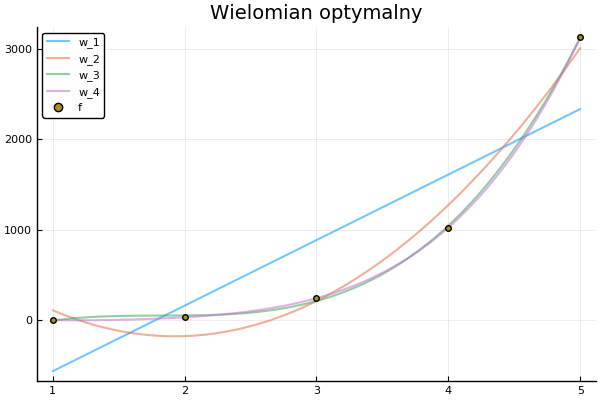

In [39]:
x = [1,2,3,4,5]
fun = [1,32,243,1024,3125]
#funkcja x^5 dla punktów równoodległych
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0) 
wiel2 = Array{Float64,1}(UndefInitializer(), 0) 
wiel3 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,fun, 1800000, wiel)
findoptimal(x,fun, 140000, wiel1)
findoptimal(x,fun, 1900, wiel2)
findoptimal(x,fun, 0.000001, wiel3)

print("wspolczynniki otrzymanego wielomianu:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel1,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel2,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel3,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
p2 = Poly(wiel2)
p3 = Poly(wiel3)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs), p2.(xs), p3.(xs)],seriesalpha = 0.55, linewidth=1.5, title="Wielomian optymalny", label=["w_1" "w_2" "w_3" "w_4"])
scatter!(x, fun, label="f")

wspolczynniki otrzymanego wielomianu:[-265.255247074633, 545.8463948108332]
wspolczynniki otrzymanego wielomianu:[144.58289220813555, -801.0623864387057, 279.2684482229699]
wspolczynniki otrzymanego wielomianu:[-4.11489451543483, 51.6572888882677, -146.65373916326558, 52.29737169599279]
wspolczynniki otrzymanego wielomianu:[0.09000000000067393, -1.6980000000085693, 9.88600000002518, -19.910000000011618, 8.600000000001383]


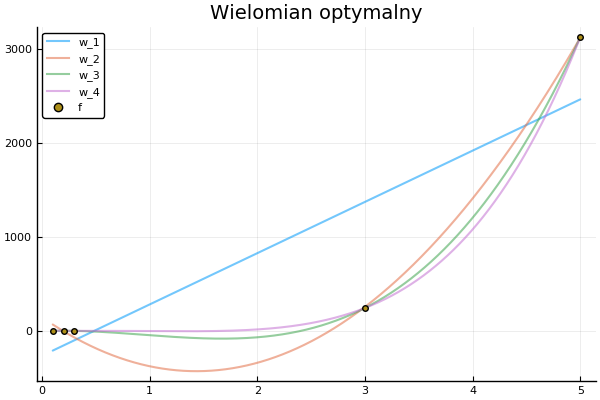

In [40]:
x = [0.1,0.2,0.3,3,5]
fun = [0.00001,0.00032,0.00243,243,3125]
#funkcja x^5
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0) 
wiel2 = Array{Float64,1}(UndefInitializer(), 0) 
wiel3 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,fun, 1800000, wiel)
findoptimal(x,fun, 10000, wiel1)
findoptimal(x,fun, 1, wiel2)
findoptimal(x,fun, 0.000001, wiel3)

print("wspolczynniki otrzymanego wielomianu:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel1,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel2,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel3,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
p2 = Poly(wiel2)
p3 = Poly(wiel3)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs), p2.(xs), p3.(xs)],seriesalpha = 0.55, linewidth=1.5, title="Wielomian optymalny", label=["w_1" "w_2" "w_3" "w_4"])
scatter!(x, fun, label="f")

wspolczynniki otrzymanego wielomianu:[1.3471716420037914]
wspolczynniki otrzymanego wielomianu:[3.3717778769220645, -0.6748687449727576]
wspolczynniki otrzymanego wielomianu:[0.5166612113183339, 1.6611357996121128, -0.38933409076414505]
wspolczynniki otrzymanego wielomianu:[-9.018572211537057, 14.295976781412232, -5.117549011188307, 0.5253572133804624]


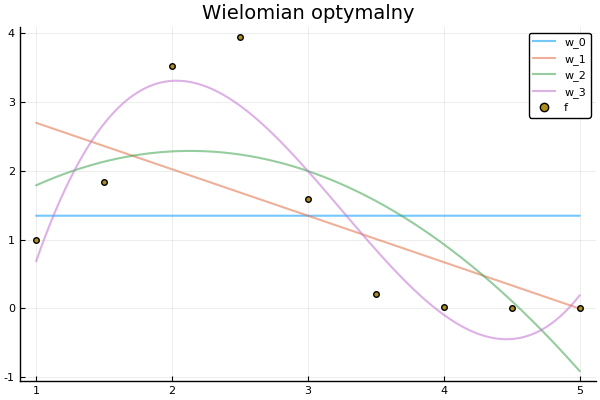

In [41]:
x = [1,1.5,2,2.5,3,3.5,4,4.5,5]
func = Array{Float64,1}(UndefInitializer(), 0)
calculfunc(x,func)
#funkcja x ^(x * sin(x))
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0) 
wiel2 = Array{Float64,1}(UndefInitializer(), 0) 
wiel3 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,func, 19, wiel)
findoptimal(x,func, 12, wiel1)
findoptimal(x,func, 9, wiel2)
findoptimal(x,func, 3, wiel3)

print("wspolczynniki otrzymanego wielomianu:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel1,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel2,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel3,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
p2 = Poly(wiel2)
p3 = Poly(wiel3)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs), p2.(xs), p3.(xs)],seriesalpha = 0.55, linewidth=1.5, title="Wielomian optymalny", label=["w_0" "w_1" "w_2" "w_3"])
scatter!(x, func, label="f")

wspolczynniki otrzymanego wielomianu:[0.7353604381775344]
wspolczynniki otrzymanego wielomianu:[1.7480011887082683, -0.35448141296689184]
wspolczynniki otrzymanego wielomianu:[-0.4807877553910874, 1.9230699054272147, -0.37314941735662616]
wspolczynniki otrzymanego wielomianu:[-2.40361442374188, 4.877414747209961, -1.6889500968283169, 0.16192467953445402]


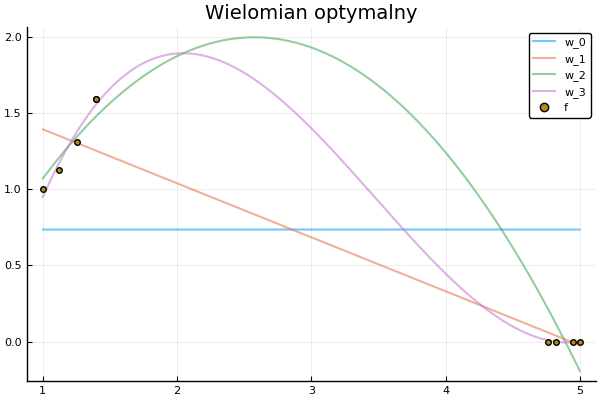

In [42]:
x = [1,1.125,1.253,1.3999,1.4,4.76324,4.8234,4.9456,5]
func = Array{Float64,1}(UndefInitializer(), 0)
calculfunc(x,func)
#funkcja x ^(x * sin(x))
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0) 
wiel2 = Array{Float64,1}(UndefInitializer(), 0) 
wiel3 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,func, 5, wiel)
findoptimal(x,func, 0.6, wiel1)
findoptimal(x,func, 0.2, wiel2)
findoptimal(x,func, 0.02, wiel3)

print("wspolczynniki otrzymanego wielomianu:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel1,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel2,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel3,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
p2 = Poly(wiel2)
p3 = Poly(wiel3)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs), p2.(xs), p3.(xs)],seriesalpha = 0.55, linewidth=1.5, title="Wielomian optymalny", label=["w_0" "w_1" "w_2" "w_3"])
scatter!(x, func, label="f")

wspolczynniki otrzymanego wielomianu:[0.0]
wspolczynniki otrzymanego wielomianu:[0.0, -0.0005072116028166325]


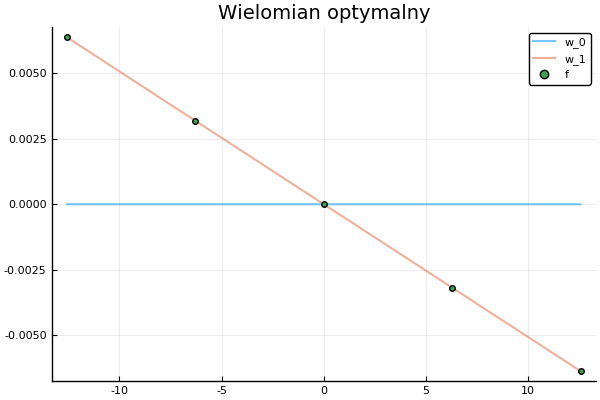

In [43]:
x = [-12.56, -6.28, 0, 6.28, 12.56]
func = Array{Float64,1}(UndefInitializer(), 0)
calculfunc2(x,func)
#funkcja sin(x) dla punktów równoodległych
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,func, 0.0002, wiel)
findoptimal(x,func, 0.0000000000001, wiel1)

print("wspolczynniki otrzymanego wielomianu:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel1,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs)],seriesalpha = 0.55, linewidth=1.5, title="Wielomian optymalny", label=["w_0" "w_1"])
scatter!(x, func, label="f")

wspolczynniki otrzymanego wielomianu:[-0.005273511614071652]
wspolczynniki otrzymanego wielomianu:[-0.0025031473236536168, -0.0011046109610917208]


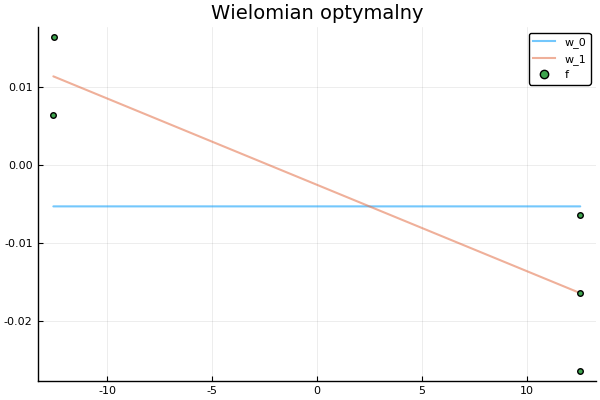

In [44]:
x = [-12.56, -12.55, 12.54, 12.55, 12.56]
func = Array{Float64,1}(UndefInitializer(), 0)
calculfunc2(x,func)
#funkcja sin(x) dla punktów różnoodległych
wiel = Array{Float64,1}(UndefInitializer(), 0)
wiel1 = Array{Float64,1}(UndefInitializer(), 0)
wiel2 = Array{Float64,1}(UndefInitializer(), 0)
findoptimal(x,func, 0.1, wiel)
findoptimal(x,func, 0.001, wiel1)

print("wspolczynniki otrzymanego wielomianu:",wiel,"\n")
print("wspolczynniki otrzymanego wielomianu:",wiel1,"\n")
pyplot()
p = Poly(wiel)
p1 = Poly(wiel1)
xs = range(x[1], stop=x[length(x)], length=10000)
plot(xs, [p.(xs), p1.(xs)],seriesalpha = 0.55, linewidth=1.5, title="Wielomian optymalny", label=["w_0" "w_1"])
scatter!(x, func, label="f")